In [5]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm
import os
import json
import zstandard as zstd

SFT_MODEL = "allenai/Llama-3.1-Tulu-3-8B-SFT"
RL_MODEL  = "allenai/Llama-3.1-Tulu-3-8B-DPO"

tokenizer = AutoTokenizer.from_pretrained(SFT_MODEL)

model_sft = AutoModelForCausalLM.from_pretrained(
    SFT_MODEL,
    torch_dtype=torch.bfloat16,
    device_map="cpu",
    cache_dir="/shared/storage-01/huggingface/models/"
)
model_rl = AutoModelForCausalLM.from_pretrained(
    RL_MODEL,
    torch_dtype=torch.bfloat16,
    device_map="cpu",
    cache_dir="/shared/storage-01/huggingface/models/"
)

all_deltas = []
param_sizes = []
sft_params = []
rl_state_dict = model_rl.state_dict()
sft_state_dict = model_sft.state_dict()

for name_sft, param_sft in tqdm(model_sft.named_parameters()):
    if name_sft not in rl_state_dict:
        print("woops")
for name_rl, param_rl in tqdm(model_rl.named_parameters()):
    if name_rl not in sft_state_dict:
        print("woops")

delta_dict = {}
with torch.no_grad():
    for name_sft, param_sft in tqdm(model_sft.named_parameters()):
        try:
            param_rl = rl_state_dict[name_sft].to(param_sft.device)
            delta = param_rl - param_sft.data
            delta_dict[name_sft] = delta
        except Exception as e:
            print(e)

def compression_ratio(t: torch.Tensor, level: int = 10):
    if t.device.type != "cpu":
        t = t.to("cpu")
    t = t.contiguous()
    raw = t.float().numpy().tobytes()
    c = zstd.ZstdCompressor(level=level)
    comp = c.compress(raw)
    orig_n = len(raw)
    comp_n = len(comp)
    return comp_n / orig_n if orig_n else 0.0, orig_n, comp_n

layer_metrics = {}
ratios = []

for key in tqdm(delta_dict.keys()):
    if 'layernorm' in key or len(delta_dict[key].shape) <= 1:
        continue

    r, orig_n, comp_n = compression_ratio(delta_dict[key])

    ratios.append(r)

    layer_metrics[key] = {
        "shape": list(delta_dict[key].shape),
        "original_bytes": orig_n,
        "compressed_bytes": comp_n,
        "compression_ratio": r
    }

    print(layer_metrics[key])

mean = sum(ratios) / len(ratios) if ratios else 0.0
print(mean)

with open("layer_compression_metrics.json", "w") as f:
    json.dump(layer_metrics, f, indent=2)
print("metrics -> layer_compression_metrics.json")


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

291it [00:00, 4454.23it/s]
291it [00:00, 4395.09it/s]
291it [00:02, 125.57it/s]
  0%|          | 1/291 [01:04<5:12:24, 64.64s/it]

{'shape': [128264, 4096], 'original_bytes': 2101477376, 'compressed_bytes': 208161427, 'compression_ratio': 0.09905480276747933}


  1%|          | 2/291 [01:07<2:16:05, 28.25s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 10291052, 'compression_ratio': 0.1533486247062683}


  1%|          | 3/291 [01:08<1:15:04, 15.64s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 2176501, 'compression_ratio': 0.12972956895828247}


  1%|▏         | 4/291 [01:08<46:46,  9.78s/it]  

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 2881053, 'compression_ratio': 0.1717241406440735}


  2%|▏         | 5/291 [01:11<34:34,  7.25s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 9343225, 'compression_ratio': 0.13922490179538727}


  2%|▏         | 6/291 [01:19<35:14,  7.42s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 24664971, 'compression_ratio': 0.10501048820359367}


  2%|▏         | 7/291 [01:27<36:04,  7.62s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 25899137, 'compression_ratio': 0.11026491863386971}


  3%|▎         | 8/291 [01:35<36:36,  7.76s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 26022310, 'compression_ratio': 0.11078932455607823}


  4%|▍         | 11/291 [01:37<17:08,  3.67s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6396951, 'compression_ratio': 0.09532199800014496}


  4%|▍         | 12/291 [01:37<13:50,  2.98s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1361980, 'compression_ratio': 0.08118033409118652}


  4%|▍         | 13/291 [01:38<11:16,  2.43s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 2258909, 'compression_ratio': 0.13464146852493286}


  5%|▍         | 14/291 [01:41<11:24,  2.47s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 8643654, 'compression_ratio': 0.12880048155784607}


  5%|▌         | 15/291 [01:48<17:32,  3.81s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 24315115, 'compression_ratio': 0.10352098516055516}


  5%|▌         | 16/291 [01:56<22:33,  4.92s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 25524634, 'compression_ratio': 0.10867048161370414}


  6%|▌         | 17/291 [02:04<26:17,  5.76s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 25635587, 'compression_ratio': 0.10914286119597298}


  7%|▋         | 20/291 [02:06<13:22,  2.96s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6096107, 'compression_ratio': 0.09083907306194305}


  7%|▋         | 21/291 [02:06<10:57,  2.43s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1221933, 'compression_ratio': 0.07283288240432739}


  8%|▊         | 22/291 [02:07<09:09,  2.04s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 2442758, 'compression_ratio': 0.14559972286224365}


  8%|▊         | 23/291 [02:10<09:49,  2.20s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 9033375, 'compression_ratio': 0.13460777699947357}


  8%|▊         | 24/291 [02:17<15:50,  3.56s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 23933067, 'compression_ratio': 0.10189442549433027}


  9%|▊         | 25/291 [02:25<20:57,  4.73s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 25596714, 'compression_ratio': 0.10897736038480486}


  9%|▉         | 26/291 [02:33<24:44,  5.60s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 25578263, 'compression_ratio': 0.10889880572046552}


 10%|▉         | 29/291 [02:35<12:38,  2.90s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 5942792, 'compression_ratio': 0.0885545015335083}


 10%|█         | 30/291 [02:35<10:21,  2.38s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1170461, 'compression_ratio': 0.06976491212844849}


 11%|█         | 31/291 [02:36<08:38,  1.99s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 2229726, 'compression_ratio': 0.13290202617645264}


 11%|█         | 32/291 [02:38<09:06,  2.11s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 8184971, 'compression_ratio': 0.12196557223796844}


 11%|█▏        | 33/291 [02:46<14:50,  3.45s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 23325389, 'compression_ratio': 0.09930725182805743}


 12%|█▏        | 34/291 [02:54<19:58,  4.66s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 25854939, 'compression_ratio': 0.1100767467703138}


 12%|█▏        | 35/291 [03:02<23:50,  5.59s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 26065239, 'compression_ratio': 0.11097209368433271}


 13%|█▎        | 38/291 [03:03<12:11,  2.89s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 5997103, 'compression_ratio': 0.08936379849910736}


 13%|█▎        | 39/291 [03:04<09:58,  2.38s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1154097, 'compression_ratio': 0.068789541721344}


 14%|█▎        | 40/291 [03:04<08:18,  1.99s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 2174712, 'compression_ratio': 0.1296229362487793}


 14%|█▍        | 41/291 [03:07<08:46,  2.11s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 8197374, 'compression_ratio': 0.12215039134025574}


 14%|█▍        | 42/291 [03:14<14:10,  3.42s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 22909848, 'compression_ratio': 0.09753809656415667}


 15%|█▍        | 43/291 [03:22<19:18,  4.67s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 26327033, 'compression_ratio': 0.11208667499678475}


 15%|█▌        | 44/291 [03:30<23:09,  5.63s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 26558694, 'compression_ratio': 0.11307296582630702}


 16%|█▌        | 47/291 [03:32<11:51,  2.92s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6108997, 'compression_ratio': 0.09103114902973175}


 16%|█▋        | 48/291 [03:33<09:42,  2.40s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1184660, 'compression_ratio': 0.07061123847961426}


 17%|█▋        | 49/291 [03:33<08:07,  2.01s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 2374121, 'compression_ratio': 0.14150863885879517}


 17%|█▋        | 50/291 [03:36<08:38,  2.15s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 8612299, 'compression_ratio': 0.12833325564861298}


 18%|█▊        | 51/291 [03:43<13:47,  3.45s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 22832113, 'compression_ratio': 0.09720714177404131}


 18%|█▊        | 52/291 [03:51<18:40,  4.69s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 26261260, 'compression_ratio': 0.11180664811815534}


 18%|█▊        | 53/291 [03:59<22:22,  5.64s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 26565970, 'compression_ratio': 0.11310394321169172}


 19%|█▉        | 56/291 [04:01<11:23,  2.91s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 5880522, 'compression_ratio': 0.08762660622596741}


 20%|█▉        | 57/291 [04:01<09:18,  2.39s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1108629, 'compression_ratio': 0.06607943773269653}


 20%|█▉        | 58/291 [04:02<07:46,  2.00s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 2300399, 'compression_ratio': 0.13711446523666382}


 20%|██        | 59/291 [04:05<08:15,  2.13s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 8429103, 'compression_ratio': 0.12560342252254486}


 21%|██        | 60/291 [04:12<13:16,  3.45s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 22998779, 'compression_ratio': 0.09791671804019383}


 21%|██        | 61/291 [04:20<18:01,  4.70s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 26477686, 'compression_ratio': 0.1127280763217381}


 21%|██▏       | 62/291 [04:28<21:38,  5.67s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 26864957, 'compression_ratio': 0.11437687277793884}


 22%|██▏       | 65/291 [04:30<11:03,  2.93s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6110092, 'compression_ratio': 0.09104746580123901}


 23%|██▎       | 66/291 [04:30<09:02,  2.41s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1125862, 'compression_ratio': 0.06710660457611084}


 23%|██▎       | 67/291 [04:31<07:32,  2.02s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 2335454, 'compression_ratio': 0.13920390605926514}


 23%|██▎       | 68/291 [04:34<07:59,  2.15s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 8502799, 'compression_ratio': 0.12670157849788666}


 24%|██▎       | 69/291 [04:41<12:54,  3.49s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 23584691, 'compression_ratio': 0.10041122351373945}


 24%|██▍       | 70/291 [04:49<17:28,  4.74s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 26633972, 'compression_ratio': 0.1133934600012643}


 24%|██▍       | 71/291 [04:57<20:58,  5.72s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 27190632, 'compression_ratio': 0.11576342582702637}


 25%|██▌       | 74/291 [04:59<10:43,  2.96s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6262304, 'compression_ratio': 0.09331560134887695}


 26%|██▌       | 75/291 [05:00<08:46,  2.44s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1195073, 'compression_ratio': 0.0712319016456604}


 26%|██▌       | 76/291 [05:00<07:18,  2.04s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 2356676, 'compression_ratio': 0.14046883583068848}


 26%|██▋       | 77/291 [05:03<07:45,  2.17s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 8625626, 'compression_ratio': 0.12853184342384338}


 27%|██▋       | 78/291 [05:10<12:31,  3.53s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 23885472, 'compression_ratio': 0.10169179098946708}


 27%|██▋       | 79/291 [05:19<16:59,  4.81s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 27144179, 'compression_ratio': 0.115565653358187}


 27%|██▋       | 80/291 [05:27<20:25,  5.81s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 27704252, 'compression_ratio': 0.11795014994485038}


 29%|██▊       | 83/291 [05:29<10:25,  3.01s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6304295, 'compression_ratio': 0.09394131600856781}


 29%|██▉       | 84/291 [05:29<08:31,  2.47s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1209190, 'compression_ratio': 0.07207334041595459}


 29%|██▉       | 85/291 [05:30<07:05,  2.06s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 2250202, 'compression_ratio': 0.13412249088287354}


 30%|██▉       | 86/291 [05:33<07:26,  2.18s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 8423767, 'compression_ratio': 0.1255239099264145}


 30%|██▉       | 87/291 [05:40<12:00,  3.53s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 23747252, 'compression_ratio': 0.1011033228465489}


 30%|███       | 88/291 [05:48<16:14,  4.80s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 26928063, 'compression_ratio': 0.11464554497173854}


 31%|███       | 89/291 [05:57<19:32,  5.81s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 27736192, 'compression_ratio': 0.1180861336844308}


 32%|███▏      | 92/291 [05:59<09:59,  3.01s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6406204, 'compression_ratio': 0.09545987844467163}


 32%|███▏      | 93/291 [05:59<08:10,  2.48s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1215578, 'compression_ratio': 0.07245409488677979}


 32%|███▏      | 94/291 [06:00<06:48,  2.08s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 2430857, 'compression_ratio': 0.14489036798477173}


 33%|███▎      | 95/291 [06:02<07:14,  2.22s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 8907700, 'compression_ratio': 0.13273507356643677}


 33%|███▎      | 96/291 [06:10<11:42,  3.60s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 24460758, 'compression_ratio': 0.10414105653762817}


 33%|███▎      | 97/291 [06:18<15:46,  4.88s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 27337251, 'compression_ratio': 0.11638765249933515}


 34%|███▎      | 98/291 [06:27<18:57,  5.90s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 28257998, 'compression_ratio': 0.12030770948954991}


 35%|███▍      | 101/291 [06:29<09:41,  3.06s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6602292, 'compression_ratio': 0.09838181734085083}


 35%|███▌      | 102/291 [06:29<07:55,  2.52s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1244910, 'compression_ratio': 0.07420241832733154}


 35%|███▌      | 103/291 [06:30<06:36,  2.11s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 2498250, 'compression_ratio': 0.14890730381011963}


 36%|███▌      | 104/291 [06:33<07:00,  2.25s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 9036619, 'compression_ratio': 0.1346561163663864}


 36%|███▌      | 105/291 [06:41<11:24,  3.68s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 25287871, 'compression_ratio': 0.10766246914863586}


 36%|███▋      | 106/291 [06:49<15:24,  5.00s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 28225468, 'compression_ratio': 0.12016921383993966}


 37%|███▋      | 107/291 [06:58<18:29,  6.03s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 28870917, 'compression_ratio': 0.12291719658034188}


 38%|███▊      | 110/291 [07:00<09:23,  3.11s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6421428, 'compression_ratio': 0.09568673372268677}


 38%|███▊      | 111/291 [07:00<07:40,  2.56s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1249671, 'compression_ratio': 0.07448619604110718}


 38%|███▊      | 112/291 [07:01<06:22,  2.14s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 2382675, 'compression_ratio': 0.14201849699020386}


 39%|███▉      | 113/291 [07:04<06:42,  2.26s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 8816104, 'compression_ratio': 0.1313701868057251}


 39%|███▉      | 114/291 [07:12<11:01,  3.74s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 25997131, 'compression_ratio': 0.1106821256024497}


 40%|███▉      | 115/291 [07:20<14:47,  5.04s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 28388150, 'compression_ratio': 0.12086182832717896}


 40%|███▉      | 116/291 [07:29<17:41,  6.06s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 28897308, 'compression_ratio': 0.12302955559321813}


 41%|████      | 119/291 [07:31<08:59,  3.14s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6572049, 'compression_ratio': 0.0979311615228653}


 41%|████      | 120/291 [07:31<07:21,  2.58s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1268260, 'compression_ratio': 0.07559418678283691}


 42%|████▏     | 121/291 [07:32<06:06,  2.16s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 2394893, 'compression_ratio': 0.14274674654006958}


 42%|████▏     | 122/291 [07:35<06:23,  2.27s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 8821855, 'compression_ratio': 0.13145588338375092}


 42%|████▏     | 123/291 [07:42<10:22,  3.71s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 25465028, 'compression_ratio': 0.10841671058109828}


 43%|████▎     | 124/291 [07:51<13:52,  4.98s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 27785528, 'compression_ratio': 0.11829618045261928}


 43%|████▎     | 125/291 [07:59<16:33,  5.99s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 28380671, 'compression_ratio': 0.12082998667444501}


 44%|████▍     | 128/291 [08:02<08:26,  3.11s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6810664, 'compression_ratio': 0.10148680210113525}


 44%|████▍     | 129/291 [08:02<06:54,  2.56s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1292371, 'compression_ratio': 0.07703131437301636}


 45%|████▍     | 130/291 [08:03<05:44,  2.14s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 2467522, 'compression_ratio': 0.14707577228546143}


 45%|████▌     | 131/291 [08:05<06:01,  2.26s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 8786764, 'compression_ratio': 0.1309329867362976}


 45%|████▌     | 132/291 [08:13<09:46,  3.69s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 25284013, 'compression_ratio': 0.10764604381152562}


 46%|████▌     | 133/291 [08:22<13:07,  4.98s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 28023175, 'compression_ratio': 0.11930795652525765}


 46%|████▌     | 134/291 [08:30<15:38,  5.98s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 28352399, 'compression_ratio': 0.12070961935179574}


 47%|████▋     | 137/291 [08:32<07:57,  3.10s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6764785, 'compression_ratio': 0.10080315172672272}


 47%|████▋     | 138/291 [08:33<06:30,  2.55s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1278128, 'compression_ratio': 0.07618236541748047}


 48%|████▊     | 139/291 [08:33<05:23,  2.13s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 2342916, 'compression_ratio': 0.1396486759185791}


 48%|████▊     | 140/291 [08:36<05:36,  2.23s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 8418911, 'compression_ratio': 0.12545154988765717}


 48%|████▊     | 141/291 [08:43<08:57,  3.58s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 24141180, 'compression_ratio': 0.10278046131134033}


 49%|████▉     | 142/291 [08:51<11:58,  4.83s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 26865434, 'compression_ratio': 0.11437890359333583}


 49%|████▉     | 143/291 [09:00<14:17,  5.80s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 27446575, 'compression_ratio': 0.11685309665543693}


 50%|█████     | 146/291 [09:02<07:15,  3.00s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6380787, 'compression_ratio': 0.0950811356306076}


 51%|█████     | 147/291 [09:02<05:55,  2.47s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1264597, 'compression_ratio': 0.07537585496902466}


 51%|█████     | 148/291 [09:03<04:55,  2.07s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 2337588, 'compression_ratio': 0.13933110237121582}


 51%|█████     | 149/291 [09:05<05:09,  2.18s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 8411389, 'compression_ratio': 0.12533946335315704}


 52%|█████▏    | 150/291 [09:13<08:14,  3.51s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 23455361, 'compression_ratio': 0.09986060432025365}


 52%|█████▏    | 151/291 [09:21<11:03,  4.74s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 26328505, 'compression_ratio': 0.11209294199943542}


 52%|█████▏    | 152/291 [09:29<13:11,  5.70s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 26915557, 'compression_ratio': 0.11459230099405561}


 53%|█████▎    | 155/291 [09:31<06:42,  2.96s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6405898, 'compression_ratio': 0.09545531868934631}


 54%|█████▎    | 156/291 [09:31<05:28,  2.44s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1270426, 'compression_ratio': 0.07572329044342041}


 54%|█████▍    | 157/291 [09:32<04:32,  2.03s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 2215254, 'compression_ratio': 0.13203942775726318}


 54%|█████▍    | 158/291 [09:35<04:45,  2.14s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 8202306, 'compression_ratio': 0.1222238838672638}


 55%|█████▍    | 159/291 [09:42<07:33,  3.43s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 22835644, 'compression_ratio': 0.0972221749169486}


 55%|█████▍    | 160/291 [09:50<10:09,  4.65s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 25911376, 'compression_ratio': 0.11031702586582728}


 55%|█████▌    | 161/291 [09:58<12:07,  5.60s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 26460338, 'compression_ratio': 0.11265421765191215}


 56%|█████▋    | 164/291 [10:00<06:08,  2.90s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6027840, 'compression_ratio': 0.08982181549072266}


 57%|█████▋    | 165/291 [10:00<05:00,  2.38s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1148029, 'compression_ratio': 0.06842786073684692}


 57%|█████▋    | 166/291 [10:01<04:09,  1.99s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 2238532, 'compression_ratio': 0.13342690467834473}


 57%|█████▋    | 167/291 [10:03<04:21,  2.10s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 8042440, 'compression_ratio': 0.11984169483184814}


 58%|█████▊    | 168/291 [10:10<06:55,  3.38s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 22401065, 'compression_ratio': 0.09537196585110255}


 58%|█████▊    | 169/291 [10:18<09:20,  4.60s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 25741456, 'compression_ratio': 0.10959359577723912}


 58%|█████▊    | 170/291 [10:26<11:11,  5.55s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 26248098, 'compression_ratio': 0.11175061123711723}


 59%|█████▉    | 173/291 [10:28<05:40,  2.88s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6234748, 'compression_ratio': 0.09290498495101929}


 60%|█████▉    | 174/291 [10:28<04:38,  2.38s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1281469, 'compression_ratio': 0.07638150453567505}


 60%|██████    | 175/291 [10:29<03:50,  1.99s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 2223530, 'compression_ratio': 0.13253271579742432}


 60%|██████    | 176/291 [10:31<04:00,  2.09s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 7875043, 'compression_ratio': 0.11734728515148163}


 61%|██████    | 177/291 [10:38<06:20,  3.34s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 21837847, 'compression_ratio': 0.09297407950673785}


 61%|██████    | 178/291 [10:46<08:34,  4.55s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 25460026, 'compression_ratio': 0.10839541469301496}


 62%|██████▏   | 179/291 [10:54<10:14,  5.49s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 25820844, 'compression_ratio': 0.1099315881729126}


 63%|██████▎   | 182/291 [10:56<05:11,  2.85s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6164740, 'compression_ratio': 0.0918617844581604}


 63%|██████▎   | 183/291 [10:56<04:13,  2.35s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1230650, 'compression_ratio': 0.07335245609283447}


 63%|██████▎   | 184/291 [10:57<03:30,  1.96s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 2076891, 'compression_ratio': 0.12379235029220581}


 64%|██████▎   | 185/291 [10:59<03:38,  2.07s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 7749316, 'compression_ratio': 0.11547380685806274}


 64%|██████▍   | 186/291 [11:06<05:47,  3.31s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 21790081, 'compression_ratio': 0.09277071697371346}


 64%|██████▍   | 187/291 [11:14<07:49,  4.52s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 25388863, 'compression_ratio': 0.10809244002614703}


 65%|██████▍   | 188/291 [11:22<09:21,  5.45s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 25703443, 'compression_ratio': 0.10943175639425005}


 66%|██████▌   | 191/291 [11:24<04:43,  2.83s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6099806, 'compression_ratio': 0.0908941924571991}


 66%|██████▌   | 192/291 [11:24<03:50,  2.33s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1169162, 'compression_ratio': 0.06968748569488525}


 66%|██████▋   | 193/291 [11:25<03:10,  1.94s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 2050052, 'compression_ratio': 0.1221926212310791}


 67%|██████▋   | 194/291 [11:27<03:18,  2.04s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 7703615, 'compression_ratio': 0.11479280889034271}


 67%|██████▋   | 195/291 [11:34<05:15,  3.28s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 21673610, 'compression_ratio': 0.09227484464645386}


 67%|██████▋   | 196/291 [11:42<07:07,  4.50s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 25324584, 'compression_ratio': 0.10781877381461007}


 68%|██████▊   | 197/291 [11:50<08:31,  5.44s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 25653129, 'compression_ratio': 0.10921754581587655}


 69%|██████▊   | 200/291 [11:52<04:17,  2.83s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6081095, 'compression_ratio': 0.09061537683010101}


 69%|██████▉   | 201/291 [11:52<03:29,  2.33s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1194652, 'compression_ratio': 0.07120680809020996}


 69%|██████▉   | 202/291 [11:53<02:52,  1.94s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1979590, 'compression_ratio': 0.11799275875091553}


 70%|██████▉   | 203/291 [11:55<02:58,  2.03s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 7495425, 'compression_ratio': 0.11169053614139557}


 70%|███████   | 204/291 [12:02<04:44,  3.26s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 21535099, 'compression_ratio': 0.09168513757841927}


 70%|███████   | 205/291 [12:10<06:24,  4.48s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 25156875, 'compression_ratio': 0.1071047570024218}


 71%|███████   | 206/291 [12:17<07:39,  5.41s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 25497931, 'compression_ratio': 0.10855679426874433}


 72%|███████▏  | 209/291 [12:19<03:50,  2.81s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6034079, 'compression_ratio': 0.08991478383541107}


 72%|███████▏  | 210/291 [12:20<03:07,  2.31s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1146748, 'compression_ratio': 0.06835150718688965}


 73%|███████▎  | 211/291 [12:20<02:33,  1.92s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1845260, 'compression_ratio': 0.1099860668182373}


 73%|███████▎  | 212/291 [12:23<02:38,  2.01s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 7403477, 'compression_ratio': 0.11032040417194366}


 73%|███████▎  | 213/291 [12:29<04:13,  3.26s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 21660112, 'compression_ratio': 0.09221737725394112}


 74%|███████▎  | 214/291 [12:37<05:44,  4.47s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 25217967, 'compression_ratio': 0.10736485464232308}


 74%|███████▍  | 215/291 [12:45<06:51,  5.41s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 25528784, 'compression_ratio': 0.10868815013340541}


 75%|███████▍  | 218/291 [12:47<03:24,  2.81s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 5968655, 'compression_ratio': 0.08893989026546478}


 75%|███████▌  | 219/291 [12:47<02:46,  2.31s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1212142, 'compression_ratio': 0.07224929332733154}


 76%|███████▌  | 220/291 [12:48<02:15,  1.91s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1760282, 'compression_ratio': 0.10492098331451416}


 76%|███████▌  | 221/291 [12:50<02:19,  1.99s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 7167452, 'compression_ratio': 0.10680335760116577}


 76%|███████▋  | 222/291 [12:57<03:44,  3.25s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 21794256, 'compression_ratio': 0.09278849193028041}


 77%|███████▋  | 223/291 [13:05<05:04,  4.48s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 25285135, 'compression_ratio': 0.1076508206980569}


 77%|███████▋  | 224/291 [13:12<06:02,  5.40s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 25539880, 'compression_ratio': 0.10873539107186454}


 78%|███████▊  | 227/291 [13:14<03:00,  2.82s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6253337, 'compression_ratio': 0.09318198263645172}


 78%|███████▊  | 228/291 [13:15<02:26,  2.33s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1266370, 'compression_ratio': 0.07548153400421143}


 79%|███████▊  | 229/291 [13:15<01:59,  1.92s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1753061, 'compression_ratio': 0.10449057817459106}


 79%|███████▉  | 230/291 [13:18<02:01,  2.00s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 7159055, 'compression_ratio': 0.10667823255062103}


 79%|███████▉  | 231/291 [13:24<03:15,  3.26s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 21893540, 'compression_ratio': 0.09321119104112897}


 80%|███████▉  | 232/291 [13:32<04:24,  4.49s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 25359364, 'compression_ratio': 0.10796684878213066}


 80%|████████  | 233/291 [13:40<05:14,  5.43s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 25655800, 'compression_ratio': 0.10922891753060478}


 81%|████████  | 236/291 [13:42<02:35,  2.83s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6201579, 'compression_ratio': 0.09241072833538055}


 81%|████████▏ | 237/291 [13:43<02:05,  2.33s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1233591, 'compression_ratio': 0.0735277533531189}


 82%|████████▏ | 238/291 [13:43<01:42,  1.93s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1771315, 'compression_ratio': 0.10557860136032104}


 82%|████████▏ | 239/291 [13:45<01:44,  2.01s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 7324508, 'compression_ratio': 0.10914367437362671}


 82%|████████▏ | 240/291 [13:52<02:47,  3.29s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 22192722, 'compression_ratio': 0.09448495081492833}


 83%|████████▎ | 241/291 [14:00<03:45,  4.52s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 25529235, 'compression_ratio': 0.1086900702544621}


 83%|████████▎ | 242/291 [14:08<04:27,  5.47s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 25926322, 'compression_ratio': 0.11038065808159965}


 84%|████████▍ | 245/291 [14:10<02:10,  2.85s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6260825, 'compression_ratio': 0.09329356253147125}


 85%|████████▍ | 246/291 [14:10<01:45,  2.35s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1333692, 'compression_ratio': 0.07949423789978027}


 85%|████████▍ | 247/291 [14:11<01:25,  1.94s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1749902, 'compression_ratio': 0.1043022871017456}


 85%|████████▌ | 248/291 [14:13<01:26,  2.02s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 7357305, 'compression_ratio': 0.10963238775730133}


 86%|████████▌ | 249/291 [14:20<02:18,  3.29s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 22091363, 'compression_ratio': 0.09405341744422913}


 86%|████████▌ | 250/291 [14:28<03:04,  4.51s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 25301162, 'compression_ratio': 0.10771905524390084}


 86%|████████▋ | 251/291 [14:36<03:37,  5.44s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 25667173, 'compression_ratio': 0.10927733778953552}


 87%|████████▋ | 254/291 [14:38<01:45,  2.85s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6549677, 'compression_ratio': 0.09759779274463654}


 88%|████████▊ | 255/291 [14:38<01:24,  2.35s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1294784, 'compression_ratio': 0.07717514038085938}


 88%|████████▊ | 256/291 [14:39<01:08,  1.94s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1761409, 'compression_ratio': 0.10498815774917603}


 88%|████████▊ | 257/291 [14:41<01:08,  2.02s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 7257572, 'compression_ratio': 0.10814625024795532}


 89%|████████▊ | 258/291 [14:48<01:49,  3.31s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 22276404, 'compression_ratio': 0.09484122480664935}


 89%|████████▉ | 259/291 [14:56<02:24,  4.51s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 25136791, 'compression_ratio': 0.10701924988201686}


 89%|████████▉ | 260/291 [15:04<02:48,  5.45s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 25722293, 'compression_ratio': 0.1095120097909655}


 90%|█████████ | 263/291 [15:06<01:19,  2.86s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6651691, 'compression_ratio': 0.09911791980266571}


 91%|█████████ | 264/291 [15:06<01:03,  2.35s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1261892, 'compression_ratio': 0.07521462440490723}


 91%|█████████ | 265/291 [15:07<00:50,  1.94s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1725324, 'compression_ratio': 0.10283732414245605}


 91%|█████████▏| 266/291 [15:09<00:50,  2.01s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 7236114, 'compression_ratio': 0.10782650113105774}


 92%|█████████▏| 267/291 [15:16<01:19,  3.32s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 22550754, 'compression_ratio': 0.09600926297051567}


 92%|█████████▏| 268/291 [15:24<01:43,  4.50s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 24918565, 'compression_ratio': 0.10609015822410583}


 92%|█████████▏| 269/291 [15:32<02:00,  5.47s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 26125368, 'compression_ratio': 0.11122809137616839}


 93%|█████████▎| 272/291 [15:34<00:54,  2.88s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6984258, 'compression_ratio': 0.10407355427742004}


 94%|█████████▍| 273/291 [15:34<00:42,  2.38s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1417663, 'compression_ratio': 0.0844992995262146}


 94%|█████████▍| 274/291 [15:35<00:33,  1.96s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1570577, 'compression_ratio': 0.09361368417739868}


 95%|█████████▍| 275/291 [15:37<00:32,  2.01s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 6958052, 'compression_ratio': 0.10368305444717407}


 95%|█████████▍| 276/291 [15:44<00:49,  3.32s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 22546677, 'compression_ratio': 0.09599190524646214}


 95%|█████████▌| 277/291 [15:52<01:03,  4.50s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 24985100, 'compression_ratio': 0.10637342929840088}


 96%|█████████▌| 278/291 [16:00<01:11,  5.52s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 26743997, 'compression_ratio': 0.11386188864707947}


 97%|█████████▋| 281/291 [16:02<00:29,  2.92s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 7297957, 'compression_ratio': 0.10874803364276886}


 97%|█████████▋| 282/291 [16:03<00:21,  2.42s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1582178, 'compression_ratio': 0.09430515766143799}


 97%|█████████▋| 283/291 [16:03<00:16,  2.00s/it]

{'shape': [1024, 4096], 'original_bytes': 16777216, 'compressed_bytes': 1832307, 'compression_ratio': 0.10921400785446167}


 98%|█████████▊| 284/291 [16:05<00:14,  2.07s/it]

{'shape': [4096, 4096], 'original_bytes': 67108864, 'compressed_bytes': 7430292, 'compression_ratio': 0.11071997880935669}


 98%|█████████▊| 285/291 [16:12<00:19,  3.27s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 20974216, 'compression_ratio': 0.08929719243730817}


 98%|█████████▊| 286/291 [16:19<00:21,  4.34s/it]

{'shape': [14336, 4096], 'original_bytes': 234881024, 'compressed_bytes': 23228511, 'compression_ratio': 0.09889479620116097}


 99%|█████████▊| 287/291 [16:28<00:21,  5.42s/it]

{'shape': [4096, 14336], 'original_bytes': 234881024, 'compressed_bytes': 26813081, 'compression_ratio': 0.11415601202419826}


100%|██████████| 291/291 [17:23<00:00,  3.59s/it]

{'shape': [128264, 4096], 'original_bytes': 2101477376, 'compressed_bytes': 173737658, 'compression_ratio': 0.08267405587334764}
0.10619257854691778
metrics -> layer_compression_metrics.json


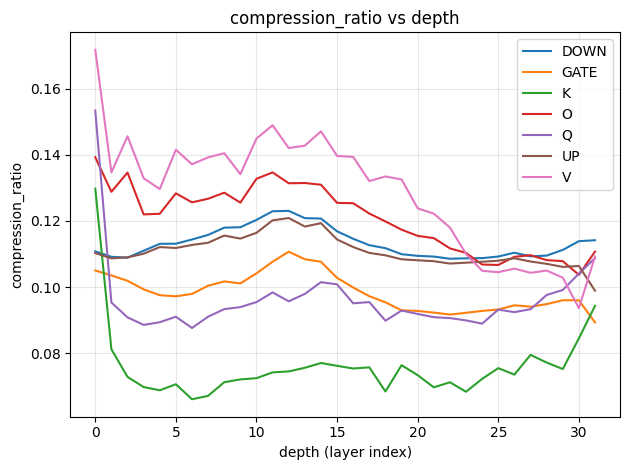

saved -> compression_vs_depth_plots


In [7]:
import json, re, os
import numpy as np
import matplotlib.pyplot as plt

with open("layer_compression_metrics.json", "r") as f:
    layer_metrics = json.load(f)

def layer_idx(name):
    m = re.search(r"model\.layers\.(\d+)\.", name)
    return int(m.group(1)) if m else None

def layer_type(name):
    if ".self_attn.q_proj." in name: return "Q"
    if ".self_attn.k_proj." in name: return "K"
    if ".self_attn.v_proj." in name: return "V"
    if ".self_attn.o_proj." in name: return "O"
    if ".mlp.gate_proj." in name: return "GATE"
    if ".mlp.up_proj." in name: return "UP"
    if ".mlp.down_proj." in name: return "DOWN"
    return None

flat = {}
for name, d in layer_metrics.items():
    i = layer_idx(name)
    t = layer_type(name)
    if i is None or t is None:
        continue
    flat.setdefault(t, []).append((i, d["compression_ratio"]))

types = sorted(flat.keys())

out_dir = "compression_vs_depth_plots"
os.makedirs(out_dir, exist_ok=True)

plt.figure()
for t in types:
    items = sorted(flat[t], key=lambda x: x[0])
    xs = [i for i, _ in items]
    ys = [r for _, r in items]
    plt.plot(xs, ys, label=t)
plt.xlabel("depth (layer index)")
plt.ylabel("compression_ratio")
plt.title("compression_ratio vs depth")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "compression_ratio_vs_depth.png"), dpi=150)
plt.show()
plt.close()

print("saved ->", out_dir)
